# Text Mining The Iliad and The Odyssey by Homer: Word Frequency and Sentiment Analysis
## Preliminary Cleaning and Text Analytics
### Loading Data and Libraries

In [1]:
import pandas as pd
import numpy as np 
import nltk
import spacy
import re
import matplotlib.pyplot as plt
from collections import defaultdict 
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk import tokenize
from nltk.probability import FreqDist
from nltk.sentiment import SentimentIntensityAnalyzer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nrclex import NRCLex
from tqdm import tqdm_notebook as tqdm
from tqdm import trange



#### Loading and preprocessing the books

Loading The Odyssey

In [2]:
ody_text=open('Odyssey.txt',"r").read()

In [3]:
print(ody_text[:500])

The Odyssey



Book I

  In a Council of the Gods, Poseidon absent, Pallas procureth
  an order for the restitution of Odysseus; and appearing to
  his son Telemachus, in human shape, adviseth him to
  complain of the Wooers before the Council of the people,
  and then go to Pylos and Sparta to inquire about his
  father.

Tell me, Muse, of that man, so ready at need, who wandered
far and wide, after he had sacked the sacred citadel of
Troy, and many were the men whose towns he saw and whose
min


Remove everythig before the start of the firts chapter 'Book I'

In [4]:
# Find the index of the first occurrence of "Book I"
start_index = ody_text.find("Book I")

# Slice the text from "Book I" onward
ody_text_cleaned = ody_text[start_index:]

# Now, ody_text_cleaned contains the text starting from "Book I"
print(ody_text_cleaned[:500])  # Print the first 500 characters to verify

Book I

  In a Council of the Gods, Poseidon absent, Pallas procureth
  an order for the restitution of Odysseus; and appearing to
  his son Telemachus, in human shape, adviseth him to
  complain of the Wooers before the Council of the people,
  and then go to Pylos and Sparta to inquire about his
  father.

Tell me, Muse, of that man, so ready at need, who wandered
far and wide, after he had sacked the sacred citadel of
Troy, and many were the men whose towns he saw and whose
mind he learnt, ye


Loading The Iliad

In [5]:
ili_text=open('Iliad.txt',"r",encoding="utf-8").read()

In [6]:
print(ili_text[:500])

﻿
THE ILIAD OF HOMER
    

BOOK I.

      The quarrel between Agamemnon and Achilles—Achilles withdraws
      from the war, and sends his mother Thetis to ask Jove to help the
      Trojans—Scene between Jove and Juno on Olympus.

      Sing, O goddess, the anger of Achilles son of Peleus, that
      brought countless ills upon the Achaeans. Many a brave soul did
      it send hurrying down to Hades, and many a hero did it yield a
      prey to dogs and vultures, for so were the counsels of Jove


Remove everything before the start of the first chapter 'BOOK I'

In [7]:
# Find the index of the first occurrence of "BOOK I"
start_index = ili_text.find("BOOK I")

# Slice the text from "Book I" onward
ili_text_cleaned = ili_text[start_index:]

# Now, ody_text_cleaned contains the text starting from "Book I"
print(ili_text_cleaned[:500])  # Print the first 500 characters to verify


BOOK I.

      The quarrel between Agamemnon and Achilles—Achilles withdraws
      from the war, and sends his mother Thetis to ask Jove to help the
      Trojans—Scene between Jove and Juno on Olympus.

      Sing, O goddess, the anger of Achilles son of Peleus, that
      brought countless ills upon the Achaeans. Many a brave soul did
      it send hurrying down to Hades, and many a hero did it yield a
      prey to dogs and vultures, for so were the counsels of Jove
      fulfilled from the d


In [8]:
books = {
    "The Odyssey": ody_text_cleaned,
    "The Iliad": ili_text_cleaned
}

Splitting into chapters and creating a dictionary containing the 2 books, and for each store the chapers.

In [9]:
#Split text in chapters
def split_into_chapters(text, book_name):
    # Regular expression pattern for chapter titles
    # Adjust based on whether it's "The Odyssey" or "The Iliad"
    if book_name == "The Odyssey":
        pattern = r'Book [IVXLCDM]+'  # Roman numerals for chapters
    else:  # "The Iliad"
        pattern = r'BOOK [IVXLCDM]+'
    
    # Find all matches of the pattern
    chapters = re.split(pattern, text)
    
    # Remove the very first split which is empty if text starts with a chapter title
    if chapters and chapters[0] == '':
        chapters = chapters[1:]
    
    # Use the pattern to find chapter titles for keys
    chapter_titles = re.findall(pattern, text)
    
    # Create a dictionary from chapter titles and chapter texts
    chapter_dict = {title: chapters[i] for i, title in enumerate(chapter_titles)}
    
    return chapter_dict

# Assuming `ody_text` and `ili_text` contain the full texts of "The Odyssey" and "The Iliad" respectively
ody_chapters = split_into_chapters(ody_text_cleaned, "The Odyssey")
ili_chapters = split_into_chapters(ili_text_cleaned, "The Iliad")

# Update the books dictionary to store the texts split by chapters
books = {
    "The Odyssey": ody_chapters,
    "The Iliad": ili_chapters
}


In [10]:
print(books["The Odyssey"]["Book I"][:500])



  In a Council of the Gods, Poseidon absent, Pallas procureth
  an order for the restitution of Odysseus; and appearing to
  his son Telemachus, in human shape, adviseth him to
  complain of the Wooers before the Council of the people,
  and then go to Pylos and Sparta to inquire about his
  father.

Tell me, Muse, of that man, so ready at need, who wandered
far and wide, after he had sacked the sacred citadel of
Troy, and many were the men whose towns he saw and whose
mind he learnt, yea, and


In [11]:
print(books["The Iliad"]["BOOK I"][:500])

.

      The quarrel between Agamemnon and Achilles—Achilles withdraws
      from the war, and sends his mother Thetis to ask Jove to help the
      Trojans—Scene between Jove and Juno on Olympus.

      Sing, O goddess, the anger of Achilles son of Peleus, that
      brought countless ills upon the Achaeans. Many a brave soul did
      it send hurrying down to Hades, and many a hero did it yield a
      prey to dogs and vultures, for so were the counsels of Jove
      fulfilled from the day on 


## Word Frequency
### Tf_idf algorithm

In [12]:
custom_stop_words=["thy", "thou", "thee", "ye", "tis","verily","even","said","now", "one", "shall", "us","upon","hath","thus"]
all_stop_words=ENGLISH_STOP_WORDS.union(custom_stop_words)

# Combine texts into a list for vectorization
texts = [ody_text_cleaned, ili_text_cleaned]  

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words=all_stop_words, max_features=10000)

# Fit and transform the texts
tfidf_matrix = vectorizer.fit_transform(texts)

# Get feature names to use as indices
feature_names = vectorizer.get_feature_names()


In [13]:
# Function to get top N tfidf values in row and return them with their corresponding feature names.
def top_tfidf_feats(row, features, top_n=30):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['feature', 'tfidf'])
    return df

# Get the top 30 words for each book
top_words_ody = top_tfidf_feats(tfidf_matrix[0].toarray()[0], feature_names)
top_words_ili = top_tfidf_feats(tfidf_matrix[1].toarray()[0], feature_names)


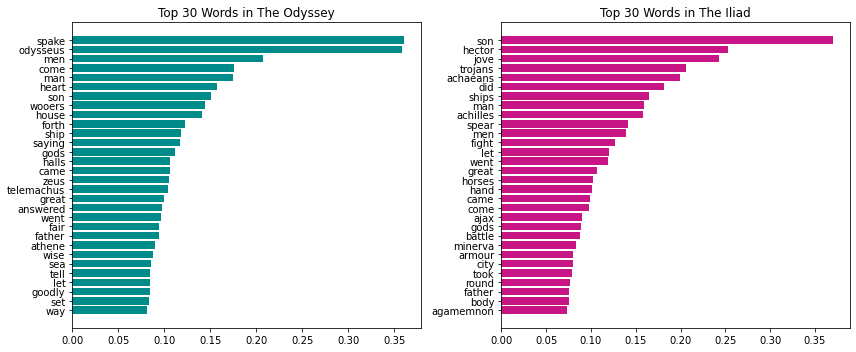

In [15]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for "The Odyssey"
axes[0].barh(top_words_ody['feature'], top_words_ody['tfidf'], color='darkcyan')
axes[0].set_title('Top 30 Words in The Odyssey')
axes[0].invert_yaxis()  # Invert y-axis to have the highest value on top

# Plot for "The Iliad"
axes[1].barh(top_words_ili['feature'], top_words_ili['tfidf'], color='mediumvioletred')
axes[1].set_title('Top 30 Words in The Iliad')
axes[1].invert_yaxis()  # Invert y-axis to have the highest value on top

plt.tight_layout()
plt.show()


#### Lemmatization

In [16]:
nlp = spacy.load("en_core_web_sm")
custom_lemma_mapping = {
    "goodly": "good",
    "spake": "speak",
    # Add more custom mappings as needed
}

# Apply custom mapping after lemmatization
lemmatized_texts_custom = []
for doc in nlp.pipe(texts):
    lemmatized_tokens = []
    for token in doc:
        if token.lemma_ in custom_lemma_mapping:
            lemmatized_tokens.append(custom_lemma_mapping[token.lemma_])
        else:
            lemmatized_tokens.append(token.lemma_)
    lemmatized_texts_custom.append(" ".join(lemmatized_tokens))

In [17]:
# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words=all_stop_words, max_features=10000)

# Apply TF-IDF to the lemmatized texts
tfidf_matrix = vectorizer.fit_transform(lemmatized_texts_custom)

# Get feature names to use as indices
feature_names = vectorizer.get_feature_names()


In [18]:
top_words_ody = top_tfidf_feats(tfidf_matrix[0].toarray()[0], feature_names)
top_words_ili = top_tfidf_feats(tfidf_matrix[1].toarray()[0], feature_names)

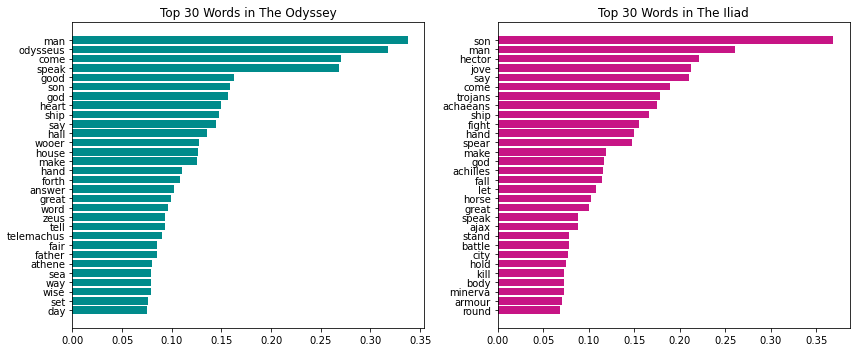

In [20]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for "The Odyssey"
axes[0].barh(top_words_ody['feature'], top_words_ody['tfidf'], color='darkcyan')
axes[0].set_title('Top 30 Words in The Odyssey')
axes[0].invert_yaxis()  # Invert y-axis to have the highest value on top

# Plot for "The Iliad"
axes[1].barh(top_words_ili['feature'], top_words_ili['tfidf'], color='mediumvioletred')
axes[1].set_title('Top 30 Words in The Iliad')
axes[1].invert_yaxis()  # Invert y-axis to have the highest value on top

plt.tight_layout()
plt.show()


#### Bi-Grams and Tri-Grams
##### Bi-Grams: non-lemmatized

In [25]:
# Configure TfidfVectorizer to capture bi-grams
vect_bigrams = TfidfVectorizer(ngram_range=(2, 2), stop_words=all_stop_words, min_df=2)

# Apply vectorizer to the lemmatized texts
tfidf_matrix_bi = vect_bigrams.fit_transform(texts)

# Get feature names (bi-grams)
feature_names = vect_bigrams.get_feature_names()

# Get top bi-grams for each document
top_bi_grams_ody = top_tfidf_feats(tfidf_matrix_bi[0].toarray()[0], feature_names, 30)
top_bi_grams_ili = top_tfidf_feats(tfidf_matrix_bi[1].toarray()[0], feature_names, 30)


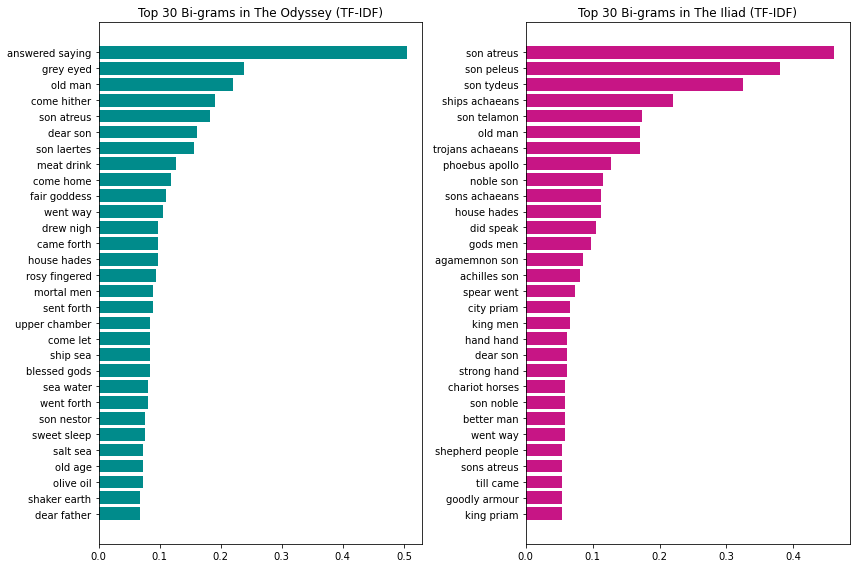

In [26]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

# Plot for The Odyssey
axes[0].barh(top_bi_grams_ody['feature'], top_bi_grams_ody['tfidf'], color='darkcyan')
axes[0].set_title('Top 30 Bi-grams in The Odyssey (TF-IDF)')
axes[0].invert_yaxis()  # To display the highest TF-IDF at the top

# Plot for The Iliad
axes[1].barh(top_bi_grams_ili['feature'], top_bi_grams_ili['tfidf'], color='mediumvioletred')
axes[1].set_title('Top 30 Bi-grams in The Iliad (TF-IDF)')
axes[1].invert_yaxis()  # To display the highest TF-IDF at the top

plt.tight_layout()
plt.show()


##### Bi-Grams: lemmatized

In [27]:
# Configure TfidfVectorizer to capture bi-grams
vect_bigrams = TfidfVectorizer(ngram_range=(2, 2), stop_words=all_stop_words, min_df=2)

# Apply vectorizer to the lemmatized texts
tfidf_matrix_bi = vect_bigrams.fit_transform(lemmatized_texts_custom)

# Get feature names (bi-grams)
feature_names = vect_bigrams.get_feature_names()

# Get top bi-grams for each document
top_bi_grams_ody = top_tfidf_feats(tfidf_matrix_bi[0].toarray()[0], feature_names, 30)
top_bi_grams_ili = top_tfidf_feats(tfidf_matrix_bi[1].toarray()[0], feature_names, 30)


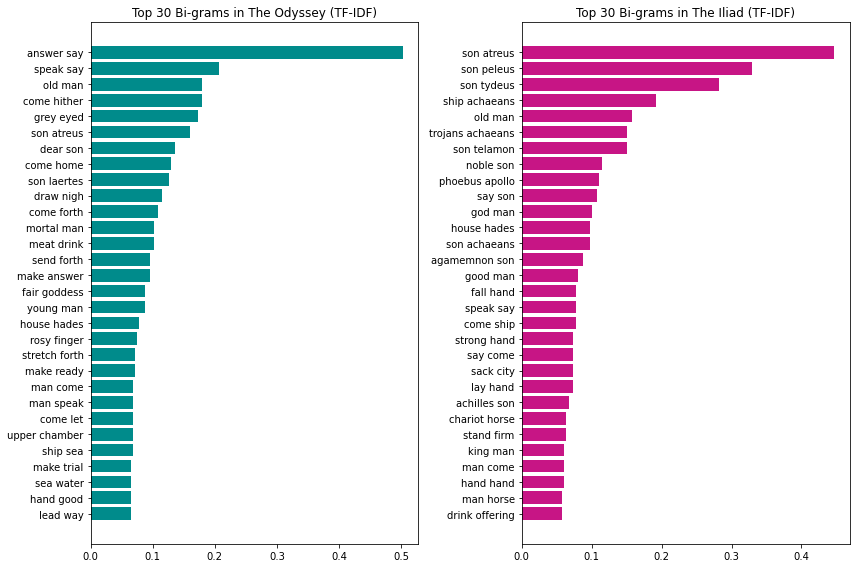

In [28]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

# Plot for The Odyssey
axes[0].barh(top_bi_grams_ody['feature'], top_bi_grams_ody['tfidf'], color='darkcyan')
axes[0].set_title('Top 30 Bi-grams in The Odyssey (TF-IDF)')
axes[0].invert_yaxis()  # To display the highest TF-IDF at the top

# Plot for The Iliad
axes[1].barh(top_bi_grams_ili['feature'], top_bi_grams_ili['tfidf'], color='mediumvioletred')
axes[1].set_title('Top 30 Bi-grams in The Iliad (TF-IDF)')
axes[1].invert_yaxis()  # To display the highest TF-IDF at the top

plt.tight_layout()
plt.show()


##### Tri-Grams: non-lemmatized

In [29]:
# Configure TfidfVectorizer to capture bi-grams
vect_trigrams = TfidfVectorizer(ngram_range=(3, 3), stop_words=all_stop_words, min_df=2)

# Apply vectorizer to the lemmatized texts
tfidf_matrix_tri = vect_trigrams.fit_transform(texts)

# Get feature names (bi-grams)
feature_names = vect_trigrams.get_feature_names()

# Get top bi-grams for each document
top_tri_grams_ody = top_tfidf_feats(tfidf_matrix_tri[0].toarray()[0], feature_names, 30)
top_tri_grams_ili = top_tfidf_feats(tfidf_matrix_tri[1].toarray()[0], feature_names, 30)


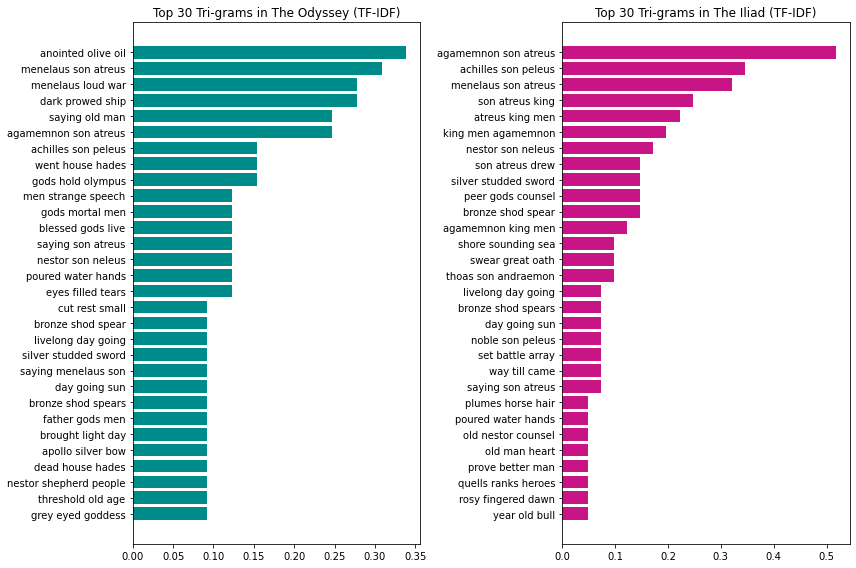

In [31]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

# Plot for The Odyssey
axes[0].barh(top_tri_grams_ody['feature'], top_tri_grams_ody['tfidf'], color='darkcyan')
axes[0].set_title('Top 30 Tri-grams in The Odyssey (TF-IDF)')
axes[0].invert_yaxis()  # To display the highest TF-IDF at the top

# Plot for The Iliad
axes[1].barh(top_tri_grams_ili['feature'], top_tri_grams_ili['tfidf'], color='mediumvioletred')
axes[1].set_title('Top 30 Tri-grams in The Iliad (TF-IDF)')
axes[1].invert_yaxis()  # To display the highest TF-IDF at the top

plt.tight_layout()
plt.show()


##### Tri-Grams: lemmatized

In [32]:
# Configure TfidfVectorizer to capture bi-grams
vect_trigrams = TfidfVectorizer(ngram_range=(3, 3), stop_words=all_stop_words, min_df=2)

# Apply vectorizer to the lemmatized texts
tfidf_matrix_tri = vect_trigrams.fit_transform(lemmatized_texts_custom)

# Get feature names (bi-grams)
feature_names = vect_trigrams.get_feature_names()

# Get top bi-grams for each document
top_tri_grams_ody = top_tfidf_feats(tfidf_matrix_tri[0].toarray()[0], feature_names, 30)
top_tri_grams_ili = top_tfidf_feats(tfidf_matrix_tri[1].toarray()[0], feature_names, 30)


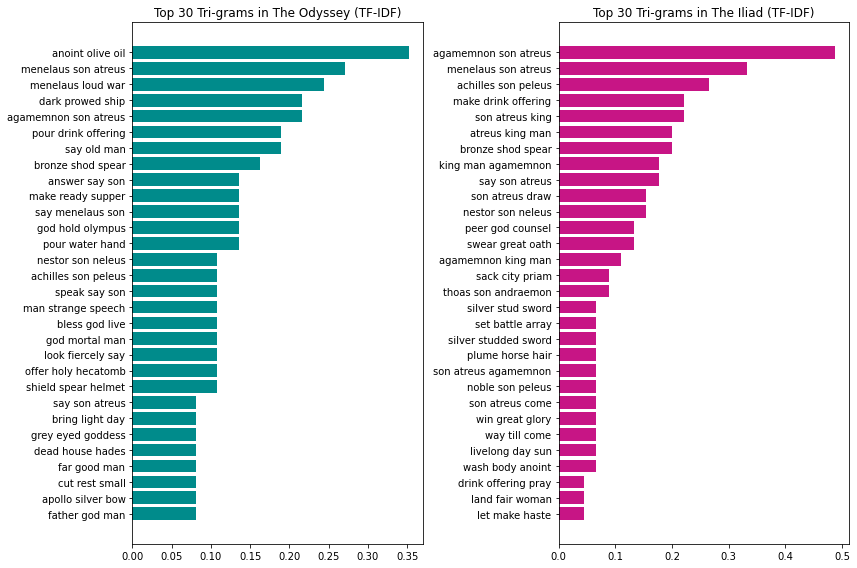

In [33]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

# Plot for The Odyssey
axes[0].barh(top_tri_grams_ody['feature'], top_tri_grams_ody['tfidf'], color='darkcyan')
axes[0].set_title('Top 30 Tri-grams in The Odyssey (TF-IDF)')
axes[0].invert_yaxis()  # To display the highest TF-IDF at the top

# Plot for The Iliad
axes[1].barh(top_tri_grams_ili['feature'], top_tri_grams_ili['tfidf'], color='mediumvioletred')
axes[1].set_title('Top 30 Tri-grams in The Iliad (TF-IDF)')
axes[1].invert_yaxis()  # To display the highest TF-IDF at the top

plt.tight_layout()
plt.show()


## Sentiment Analysis

In [34]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\utente\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [35]:
sia = SentimentIntensityAnalyzer()

In [36]:
def split_into_chapters2(text, book_name):
    # Regular expression pattern for chapter titles, adjusted to include the full title
    text = text.replace('BOOK i', 'BOOK I')
    if book_name == "The Odyssey":
        pattern = r'(Book [IVXLCDM]+)'
    else:  # "The Iliad"
        pattern = r'(BOOK [IVXLCDM]+)'
    
    # Find all matches of the pattern, including the titles in the splits
    chapters = re.split(pattern, text)[1:]  # Skip the first element if it's empty and include titles in splits
    
    # Pair titles with their respective contents
    chapter_dict = {}
    for i in range(0, len(chapters), 2):
        title = f"{chapters[i].strip()}"  # Enhance chapter title formatting
        content = chapters[i + 1].strip()
        chapter_dict[title] = content
    
    return chapter_dict
# Assuming `ody_text` and `ili_text` contain the full texts of "The Odyssey" and "The Iliad" respectively
ody_chapters = split_into_chapters2(lemmatized_texts_custom[0], "The Odyssey")
ili_chapters = split_into_chapters2(lemmatized_texts_custom[1], "The Iliad")


In [37]:
book_dict = {
    "The Odyssey": ody_chapters,
    "The Iliad": ili_chapters
}

In [39]:
for book in tqdm(book_dict, desc='Progress'):
    print(book)
    for chapter in tqdm(book_dict[book],postfix=book):
       #print('  ', chapter)
        text = book_dict[book][chapter].replace('\n', '')
        sentence_list = tokenize.sent_tokenize(text)
        sentiments = {'compound': 0.0, 'neg': 0.0, 'neu': 0.0, 'pos': 0.0}
        
        for sentence in sentence_list:
            vs = sia.polarity_scores(sentence)
            sentiments['compound'] += vs['compound']
            sentiments['neg'] += vs['neg']
            sentiments['neu'] += vs['neu']
            sentiments['pos'] += vs['pos']
            
        sentiments['compound'] = sentiments['compound'] / len(sentence_list)
        sentiments['neg'] = sentiments['neg'] / len(sentence_list)
        sentiments['neu'] = sentiments['neu'] / len(sentence_list)
        sentiments['pos'] = sentiments['pos'] / len(sentence_list)

        book_dict[book][chapter] = (chapter[0], chapter[1], sentiments)

C:\Users\utente\AppData\Local\Temp/ipykernel_13424/1261317217.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for book in tqdm(book_dict, desc='Progress'):


Progress:   0%|          | 0/2 [00:00<?, ?it/s]

The Odyssey


C:\Users\utente\AppData\Local\Temp/ipykernel_13424/1261317217.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chapter in tqdm(book_dict[book],postfix=book):


  0%|          | 0/24 [00:00<?, ?it/s, The Odyssey]

The Iliad


  0%|          | 0/22 [00:00<?, ?it/s, The Iliad]

In [40]:
compound_sentiments = [book_dict[book][chapter][2]['compound'] for book in book_dict for chapter in book_dict[book]]

In [41]:
chap = 0
for book in book_dict:
    print(book)
    book_chap = 1
    for chapter in book_dict[book]:
        print('  Chapter', book_chap, '-', chapter)
        print('     ', compound_sentiments[chap])
        book_chap += 1
        chap += 1
    print()

The Odyssey
  Chapter 1 - Book I
      0.26462242424242427
  Chapter 2 - Book II
      0.11384071856287427
  Chapter 3 - Book III
      0.20994715025906746
  Chapter 4 - Book IV
      0.18773067092651752
  Chapter 5 - Book V
      0.1995649746192894
  Chapter 6 - Book VI
      0.33698455284552825
  Chapter 7 - Book VII
      0.26043032786885245
  Chapter 8 - Book VIII
      0.2952750000000001
  Chapter 9 - Book IX
      0.11205198019801983
  Chapter 10 - Book X
      0.061156828193832606
  Chapter 11 - Book XI
      0.00850875576036866
  Chapter 12 - Book XII
      0.08587784431137721
  Chapter 13 - Book XIII
      0.272714371257485
  Chapter 14 - Book XIV
      0.19334083769633498
  Chapter 15 - Book XV
      0.25981601731601733
  Chapter 16 - Book XVI
      0.1856729729729729
  Chapter 17 - Book XVII
      0.1077129166666667
  Chapter 18 - Book XVIII
      0.16501220930232555
  Chapter 19 - Book XIX
      0.22948048780487806
  Chapter 20 - Book XX
      0.12523439490445856
  Chapter 

In [42]:
book_indices = {}
for book in book_dict:
    start = 0
    idx = 0
    for chapter in book_dict[book]:
        idx += 1
    book_indices[book] = (start, idx)

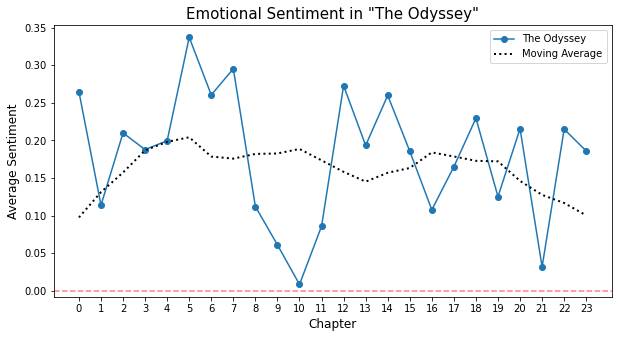

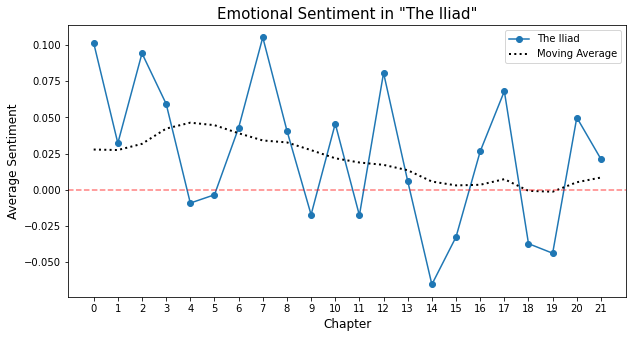

In [43]:
def moving_average(values, window):
    """Compute the moving average of a list of values, starting from the first data point."""
    weights = np.repeat(1.0, window) / window
    sma = np.convolve(values, weights, 'same')  # Use 'same' to include partial averages at the start
    return sma

# Assuming 'hp' is your dictionary containing books, chapters, and sentiments
for book in book_dict:
    chapters = list(book_dict[book].keys())  # List of chapter titles
    num_chapters = len(chapters)
    
    # Generate x values for each chapter in the current book
    x = np.arange(num_chapters)
    
    # Extract compound sentiment values for each chapter
    y = [book_dict[book][chapter][2]['compound'] for chapter in chapters]
    
    # Create a new plot for the current book
    plt.figure(figsize=(10, 5))
    
    # Plot the sentiments for the current book
    plt.plot(x, y, label=book, marker='o')
    
    # Optional: Plot the moving average for the current book
    ma = moving_average(y, 10)
    plt.plot(x, ma, color='k', linewidth=2, linestyle=':', label='Moving Average')
     
    # Add a horizontal line at y=0 to indicate neutral sentiment
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    plt.xticks(np.arange(min(x), max(x)+1, 1.0))  # Ensure ticks are set for every chapter
    # Add legend, title, and axis labels
    plt.legend(loc='best')
    plt.title(f'Emotional Sentiment in "{book}"', fontsize=15)
    plt.xlabel('Chapter', fontsize=12)
    plt.ylabel('Average Sentiment', fontsize=12)
    
    # Show the plot
    plt.show()


## NRC Emotion Lexicon

In [44]:
#from nrclex import NRCLex

def analyze_emotion_with_nrclex(text):
    # Create an NRCLex object for the text
    emotion_analyzer = NRCLex(text)
    
    # Get emotion scores
    # NRCLex provides emotion scores in a dictionary form where keys are emotions
    # and values are the frequency of words associated with each emotion in the text.
    # To get percentages, you can use emotion_analyzer.affect_frequencies
    emotions = emotion_analyzer.affect_frequencies
    
    return emotions


In [45]:
ody_chapters = split_into_chapters2(lemmatized_texts_custom[0], "The Odyssey")
ili_chapters = split_into_chapters2(lemmatized_texts_custom[1], "The Iliad")

book_dict = {
    "The Odyssey": ody_chapters,
    "The Iliad": ili_chapters
}

In [46]:
# Assuming hp is your dataset with books and chapters
for book in book_dict:
    for chapter, text in book_dict[book].items():
        # Here, we assume the text is directly stored; adjust if it's within a tuple or another structure
        emotions = analyze_emotion_with_nrclex(text)
        
        # Replace the chapter's text with a tuple (original_text, emotions_dict)
        # If the original structure includes more elements in the tuple, adjust accordingly
        book_dict[book][chapter] = (text, emotions)

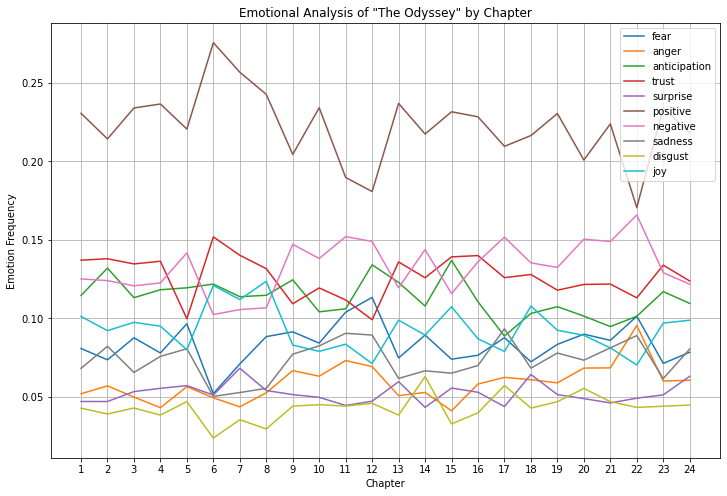

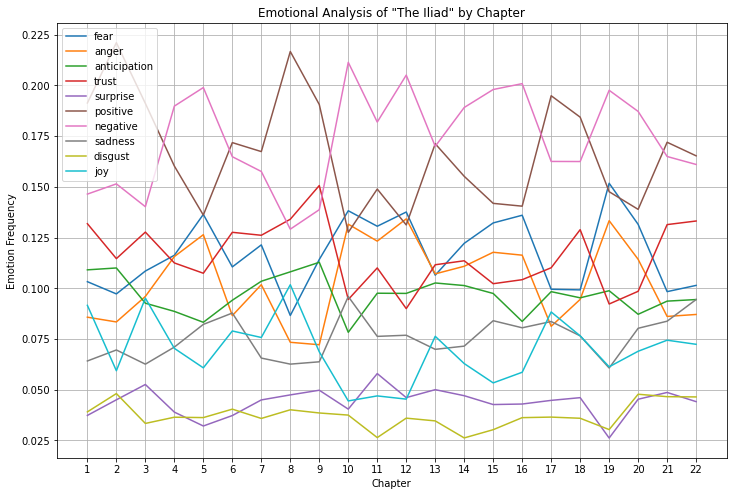

In [47]:
# Define the emotions you want to plot
emo = ["fear", "anger", "anticipation", "trust", "surprise", "positive", "negative", "sadness", "disgust", "joy"]

# Iterate through each book and plot emotions
for book in book_dict:
    plt.figure(figsize=(12, 8))
    num_chapters = len(book_dict[book])
    x = np.arange(1, num_chapters + 1)  # Chapter numbers
    
    # Initialize a dictionary to hold summed emotion scores for averaging later
    emotion_sums = {emotion: np.zeros(num_chapters) for emotion in emotions}
    
    # Accumulate emotion data
    for i, chapter in enumerate(book_dict[book], start=1):
        for emotion in emo:
            emotion_sums[emotion][i-1] = book_dict[book][chapter][1].get(emotion, 0)
    
    # Plot each emotion
    for emotion in emo:
        plt.plot(x, emotion_sums[emotion], label=emotion)
    
    plt.title(f'Emotional Analysis of "{book}" by Chapter')
    plt.xlabel('Chapter')
    plt.ylabel('Emotion Frequency')
    plt.legend()
    plt.xticks(x)  # Ensure only whole numbers (chapters) are used as ticks
    plt.grid(True)
    plt.show()


In [51]:
# Define a mapping for variant emotion labels to standard labels
emotion_label_mapping = {
    'anticip': 'anticipation',
    # Add other variants here if needed
}

def standardize_emotion_label(label):
    # Use the mapping to standardize the label, or return the label itself if no mapping is needed
    return emotion_label_mapping.get(label, label)

# Then, in your aggregation logic, standardize labels as you count them
def aggregate_emotions_for_book(book_chapters):
    aggregated_emotions = {}
    for chapter, emotions in book_chapters.items():
        for emotion, count in emotions[1].items():  # Assuming [1] is the emotions dictionary
            # Standardize the emotion label
            standardized_emotion = standardize_emotion_label(emotion)
            if standardized_emotion not in aggregated_emotions:
                aggregated_emotions[standardized_emotion] = 0
            aggregated_emotions[standardized_emotion] += count

    return aggregated_emotions

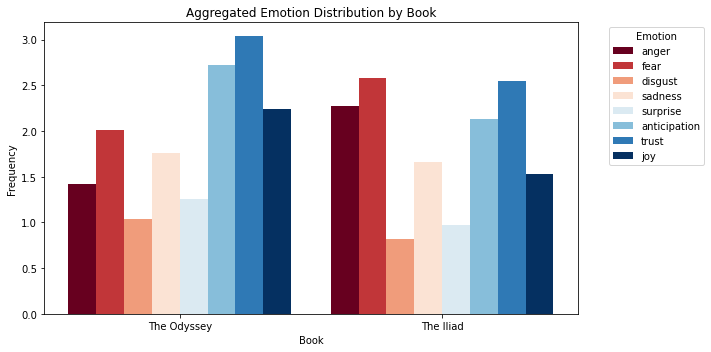

In [52]:
# Assuming 'book_dict' and 'aggregate_emotions_for_book' are defined as per your previous code
# Define a gradient from red (most negative) to blue (most positive)
emotion_list = ['anger', 'fear', 'disgust', 'sadness', 'surprise', 'anticipation', 'trust', 'joy']
colors = plt.cm.RdBu(np.linspace(0, 1, len(emotion_list)))

# Aggregate emotions for each book and standardize labels
aggregated_emotions = {}
for book_name, chapters in book_dict.items():
    aggregated_emotions[book_name] = aggregate_emotions_for_book(chapters)

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))

# Calculate bar positions
num_emotions = len(emotion_list)
bar_width = 0.35
index = np.arange(len(aggregated_emotions)) * (num_emotions * bar_width + 0.5)  # Bar groups are the base index

for emotion_idx, emotion in enumerate(emotion_list):
    values = [aggregated_emotions[book_name].get(emotion, 0) for book_name in aggregated_emotions]
    # Offset each bar within a group by the width of the bar
    bar_positions = index + (emotion_idx * bar_width)
    ax.bar(bar_positions, values, bar_width, label=emotion, color=colors[emotion_idx])

# Formatting plot
ax.set_xlabel('Book')
ax.set_ylabel('Frequency')
ax.set_title('Aggregated Emotion Distribution by Book')
ax.set_xticks(index + bar_width * (num_emotions - 1) / 2)
ax.set_xticklabels(list(aggregated_emotions.keys()))
ax.legend(title="Emotion", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


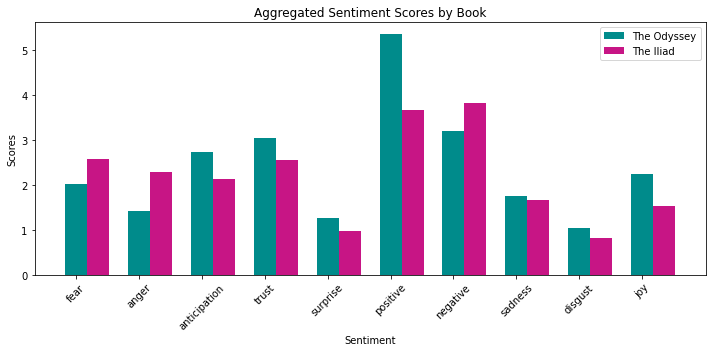

In [53]:
# Assuming the 'aggregate_emotions_for_book' function aggregates emotions for a given book's chapters
# Aggregate emotions for each book
aggregated_emotions = {book: aggregate_emotions_for_book(chapters) for book, chapters in book_dict.items()}

# Define two colors, one for each book
book_colors = ['darkcyan', 'mediumvioletred']
book_names = list(aggregated_emotions.keys())

# Assuming all books have the same set of sentiments, choose one for labels
sentiments = list(aggregated_emotions[book_names[0]].keys())

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.35
index = np.arange(len(sentiments))

for i, book in enumerate(book_names):
    # Extract the emotion scores for this book
    scores = [aggregated_emotions[book][sentiment] for sentiment in sentiments]
    # Plot bars with an offset for each book
    ax.bar(index + i * bar_width, scores, bar_width, label=book, color=book_colors[i])

# Formatting plot
ax.set_xlabel('Sentiment')
ax.set_ylabel('Scores')
ax.set_title('Aggregated Sentiment Scores by Book')
ax.set_xticks(index + bar_width / 2 - 0.5 * bar_width)
ax.set_xticklabels(sentiments, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()
